### Starting with the analysis

Calling global packages

In [1]:
import sys, os

from dotenv import load_dotenv
load_dotenv(dotenv_path='../.env')
load_dotenv()

import pickle, json
import time
import processingData
import collections, itertools, copy, operator

import nltk
import pandas
import gensim
import sklearn
import re
import string
import math
import scipy
import numpy

in the other hello\nworld


Using TensorFlow backend.


# IN processingData.py

### Packages

In [2]:
import os
import re
import nltk
import json
print("in the other",os.getenv("TEST_MULTILINE_VAR"))
nltk.data.path.append(os.getenv("NLTKDATADIR"))
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
import copy
import math



in the other hello\nworld


### Functions for first Data Preparation adding POS

In [3]:
############################
## allrecordsPreparation 1: original
############################

def allrecordsPreparation1(allrecords):
    '''
    description: tokenization and POS tagging
    input: dict of allrecords texts and data from different sources
    treatment: separating only those with posts in the forum and tokenizing the posts
    output:
    1) list of lists, each with:
    -- id
    -- username
    -- link of the post
    -- tokenized text
    -- POS tagged text
    2) list of post ids
    '''
    print('in allrecordsPreparation (len(allrecords))::',len(allrecords))
    #global var to this scope
    #forum_tonltk = []
    tktexts = []
    soup_forum = None
    forum_ids = []
    all_posedsts = []
    count = 0
    for u in allrecords:
        #block arguments
        record = u["data"]
        forumpost = record['forum']['foundjob_msg']['text']
        if forumpost == '':
            continue
        forumpostID = record['forum']['foundjob_msg']['id']
        forumpostLINK = record['forum']['foundjob_msg']['link']
        soup_forumpost = BeautifulSoup(forumpost)
        soup_forumpostTEXT = soup_forumpost.find('body').get_text()
        tksoup_forumpostTEXT = nltk.word_tokenize(soup_forumpostTEXT)

        #forum_tonltk.append(soup_forumpostTEXT)

        #listoftexts_forum.append(('f_'+forumpostID,
        #                          [w.lower() for w in tksoup_forumpostTEXT],
        #                          forumpostLINK,
        #                          u))

        modtext = []
        
        ## Get an approximation of sentences
        for w in tksoup_forumpostTEXT:
            w = w.lower()
            rws = []
            if len(w) > 1 and len({'.','-',':'}.intersection(w)) >= 1:
                #print(w)
                for punc in {'.','-',':'}.intersection(w):
                    rws = w.replace(punc, ' '+punc+' ').split()
                #print(rws)
            if len(rws) == 0:
                modtext.append(w)
            else:
                for w in rws:
                    modtext.append(w)

        ## 
        #[w.lower() for w in nltk.word_tokenize(soup_forum.find('body').get_text())]
        all_posedsts.append((
                            'f_'+forumpostID,
                            u["user"],
                            forumpostLINK,
                            modtext,
                            nltk.pos_tag(modtext)
                            ))
        #forum_ids.append(forumpostID)

        count += 1

    print("number of treated posts (len(count)) ::", count)
    #return all_posedsts, forum_ids
    return all_posedsts


############################
## allrecordsPreparation 2: revision of 1, which now includes cleaning and lemmatization plus 
## a single dataset for treated records
############################

def allrecordsPreparation2(allrecords):
    '''
    description: tokenization and POS tagging
    input: dict of allrecords texts and data from different sources
    treatment: separating only those with posts in the forum and tokenizing the posts
    output:
    1) list of lists, each with:
    -- id
    -- username
    -- link of the post
    -- tokenized text
    -- POS tagged text
    2) list of post ids
    '''
    print('in allrecordsPreparation (len(allrecords))::',len(allrecords))
    #global var to this scope
    #forum_tonltk = []
    tktexts = []
    soup_forum = None
    forum_ids = []
    all_lemmpostxts = []
    count = 0
    
       
    def HTMLtoText(u):
        #block arguments
        record = u["data"]
        forumpost = record['forum']['foundjob_msg']['text']
        if forumpost == '':
            return False
        forumpostID = record['forum']['foundjob_msg']['id']
        forumpostLINK = record['forum']['foundjob_msg']['link']
        soup_forumpost = BeautifulSoup(forumpost)
        soup_forumpostTEXT = soup_forumpost.find('body').get_text()
        tksoup_forumpostTEXT = nltk.word_tokenize(soup_forumpostTEXT)
        return forumpostID, forumpostLINK, tksoup_forumpostTEXT
    
    def approxsts(text):
        modtext = []
        for w in tksoup_forumpostTEXT:
            w = w.lower()
            rws = []
            if len(w) > 1 and len({'.','-',':'}.intersection(w)) >= 1:
                #print(w)
                for punc in {'.','-',':'}.intersection(w):
                    rws = w.replace(punc, ' '+punc+' ').split()
                #print(rws)
            if len(rws) == 0:
                modtext.append(w)
            else:
                for w in rws:
                    modtext.append(w)
        return modtext
    
    def lemmatizationofpos(postxt, lemmws):
        lemmposws = []
        for posw in postxt:
            w = posw[0]
            pos = posw[1]
            if nltk.corpus.wordnet.synsets(w):
                try:
                    n = ''
                    if nltk.corpus.wordnet.synsets(w,pos[0].lower())[0].root_hypernyms()[0].name().split('.')[0] == 'entity':
                        n = w
                    else:
                        n = nltk.corpus.wordnet.synsets(w,pos[0].lower())[0].root_hypernyms()[0].name().split('.')[0]
                    if pos[0] == 'V':
                        n = nltk.stem.wordnet.WordNetLemmatizer().lemmatize(w,'v')
                    if pos == 'NNS' or pos == 'NN$':
                        n = nltk.stem.wordnet.WordNetLemmatizer().lemmatize(w)
                    #print(w, nltk.corpus.wordnet.synsets(w,pos[0].lower())[0].root_hypernyms(), n)
                    lemmposws.append((w,True,n,pos))
                    lemmws.append(n)
                except KeyError: #in some cases the POS tag is not recognised by wordnet synset
                    print("pos KeyErrors", w,pos)
                    lemmposws.append((w,False,w,pos))
                    lemmws.append(w)
                except IndexError:
                    print("IndexErrors (not found)", w,pos) #in some cases (w,pos) pair was not found at some point of the synsets root hyernyms
                    #print(nltk.corpus.wordnet.synsets(w,pos[0].lower()))
                    lemmposws.append((w,False,w,pos))
                    lemmws.append(w)
            else:
                #print(w, [])
                lemmposws.append((w,False,w,pos))
                lemmws.append(w)
        return lemmposws
      
    
    lemmws = []
    lemmposrecs = []
    
    for u in allrecords:
        ## Getting the data as a text from HTML format (raw dataset)
        userdata = HTMLtoText(u)
        if userdata != False:
            forumpostID, forumpostLINK, tksoup_forumpostTEXT = userdata
            
            ## Get an approximation of sentences
            modtxt = approxsts(tksoup_forumpostTEXT)
            
            ## POS
            postxt = nltk.pos_tag(modtxt)
            
            ## Lemm text
            lemmpostxt = lemmatizationofpos(postxt,lemmws)
            
            ## Adding data to the new created dataset
            lemmposrecs.append((
                            'f_'+forumpostID,
                            u["user"],
                            forumpostLINK,
                            lemmpostxt
                            ))

    print("number of treated posts (len(count)) ::", count)
    #return all_posedsts, forum_ids
    return lemmposrecs, nltk.FreqDist(lemmws)

### Functions for Lemmatized Dataset

In [4]:
############################
## allrecordsLemmatization1: original
############################

def allrecordsLemmatization1(all_posedsts):
    '''
    description: lemmatization
    input: list of tokenized texts (sentences)
    output:
        1) same list of texts but each with the lematized words when found
        2) freqDist of the words after trying lematization
    '''
    all_lemmposedsts = []
    lemmposedwords = []

    print("-"*15+"\nFails to lematize will be printed below\n"+"-"*15)
    for posedpost in all_posedsts:
        lemmposedws = []
        merged_posedsts = posedpost[4]
                
        for posw in  merged_posedsts:
            w = posw[0]
            pos = posw[1]
            if nltk.corpus.wordnet.synsets(w):
                try:
                    n = ''
                    if nltk.corpus.wordnet.synsets(w,pos[0].lower())[0].root_hypernyms()[0].name().split('.')[0] == 'entity':
                        n = w
                    else:
                        n = nltk.corpus.wordnet.synsets(w,pos[0].lower())[0].root_hypernyms()[0].name().split('.')[0]
                    if pos[0] == 'V':
                        n = nltk.stem.wordnet.WordNetLemmatizer().lemmatize(w,'v')
                    if pos == 'NNS' or pos == 'NN$':
                        n = nltk.stem.wordnet.WordNetLemmatizer().lemmatize(w)
                    #print(w, nltk.corpus.wordnet.synsets(w,pos[0].lower())[0].root_hypernyms(), n)
                    lemmposedws.append(n)
                    lemmposedwords.append(n)
                except KeyError: #in some cases the POS tag is not recognised by wordnet synset
                    print("pos KeyErrors", w,pos)
                    lemmposedws.append(w)
                    lemmposedwords.append(w)
                except IndexError:
                    print("IndexErrors (not found)", w,pos) #in some cases (w,pos) pair was not found at some point of the synsets root hyernyms
                    #print(nltk.corpus.wordnet.synsets(w,pos[0].lower()))
                    lemmposedws.append(w)
                    lemmposedwords.append(w)                    
            else:
                #print(w, [])
                lemmposedws.append(w)
                lemmposedwords.append(w)
        
        all_lemmposedsts.append(lemmposedws)
    
    all_fd = nltk.FreqDist(lemmposedwords)
    
    return all_posedsts, all_lemmposedsts, all_fd


### Words Importance metrics

In [5]:
############################
## wordimportance_var1: original
############################
def wordimportance_var1(all_lemmposedsts, all_fd):
    '''
    description:
    
    This metric was originally called "enlargedopacity"; renamed as wordimportance_var1.
    
    "enlargedopacity" is just a variation of the TF-IDF metric to measure word importance; the naming is just arbitrary and related to its use in this specific project.
    
    The importance of a word in this case is based on the combined effect of two metrics:
    --- opacity: 1 - total count of word against total count of the most frequent word (1 - log(f_w)/log(f_maxw)):
        this range between [0,1); the metric will penalize those words that are too frequent in the corpus, giving it a small value (close to 0)
    --- sizing: 1 - (max count of a word in a text) / (total count of the word in all texts):
        this range between [0,1); this metric is mostly a dispersion metric: the smaller the value, the larger the likelihood
        that the word concentrates in only one text; it also penalises very rare words

    opacity is about a complement of a TF variation (a standard TF is corpus' term frequency).
    
    sizing is about a complement of a IDF variation (a standard IDF is log( (Total Documents) / (Documents containing the term) )).
 
    While opacity will favour the less frequent words, sizing will adjust opacity so those that are too concentrated in very few texts (too rare) get penalized.
   
    Using sizing as dispersion metric, words that are more common between different text receive better ranking.

    "enlargedopacity" is the product of the frequency of the word against the most frequent word by its dispersion in the corpus, just like TF-IDF.
    Its calculation doesn't deviate much from other variations of the standard metric (https://en.wikipedia.org/wiki/Tf%E2%80%93idf).
      
    The idea is to highlight those words that are more shared in the corpus without being too frequent ones. Those are more like (shared) topic words.

    However:
    --- Be aware that the metric is not normalized by text's length: the effect of the frequent appearance of a word because the text is long is not considered
        This could affect mostly the dispersion metric.
    --- The metric favours words that are shared; for topic modelling it will excludes words that define topics specific to few texts
    --- The metrics assign value of (close to) 0 to penalised words: that makes those words to dissappear from the radar; it is like a hard L1 measure 
    --- In fact, it assigns value of 0 to less and very frequent words, suggesting they are the same when they are not
    
    input:
        1) tokenized list of texts
        2) freqDist of lemmatized words
    
    output: wordimportance_var1 
    '''

    maxdiv = math.log(sorted(all_fd.items(), key=lambda x: x[1], reverse=True)[0][1])
    opacity = dict([(k, 1-math.log(v)/maxdiv) for k,v in all_fd.items()])
    sizing_matrix = dict([(k, [0]*len(norm_posedsts)) for k in list(all_fd.keys())])
    data_out = []
    l = 0
    for i,lemmpos_t in enumerate(all_lemmposedsts):
        for k, lemmpos_w in enumerate(lemmpos_t):
            sizing_matrix[lemmpos_w][i] = sizing_matrix[lemmpos_w][i] + 1
       
    sizing = dict([(k, 1 - max(vector)/sum(vector)) for k, vector in sizing_matrix.items()])
    
    wordimportance_var1 = dict([(k, valsizing*opacity[k]) for k, valsizing in sizing.items()])

    return wordimportance

############################
## wordimportance_var2: modified to fit my heuristic for word ranking 
############################
def wordimportance_var2(all_lemmposedsts, all_fd):
    '''
    description:
    
    This metric tries to solve some of the issues that appeared in `wordimportance_var1` metric, in particular the values of zero.
    
    This is done by setting lower bounds when required.
    
    --- In the case of opacity, a non-zero lower bound is set by changing the equation to the following:
        ```
        if 1-math.log(v)/maxdiv == 0: 1-math.log(maxdiv-1)/maxdiv # 1-math.log(v)/maxdiv == 0 if v == maxdiv
        ```
    --- In the case of sizing, a redefinition of the metric force a non-zero lower bound as well as rebumpimg rare terms in documents:
        ```
        (sum(vector)-max(vector))/sum(vector)
        ```
    
    input:
        1) tokenized list of texts
        2) freqDist of lemmatized words
    
    output: wordimportance 
    '''

    maxdiv = math.log(sorted(all_fd.items(), key=lambda x: x[1], reverse=True)[0][1])
    opacity = dict([(k, 1-math.log(v)/maxdiv) if 1-math.log(v)/maxdiv != 0 else (k,1-math.log(maxdiv-1)/maxdiv) for k,v in all_fd.items()])
    sizing_matrix = dict([(k, [0]*len(all_lemmposedsts)) for k in list(all_fd.keys())])
    data_out = []
    l = 0
    for i,lemmpos_t in enumerate(all_lemmposedsts):
        for k, lemmpos_w in enumerate(lemmpos_t):
            sizing_matrix[lemmpos_w][i] = sizing_matrix[lemmpos_w][i] + 1
       
    sizing = dict([(k, (sum(vector)-max(vector))/sum(vector)) for k, vector in sizing_matrix.items()])
    
    wordimportance = dict([(k, valsizing*opacity[k]) for k, valsizing in sizing.items()])

    return wordimportance


############################
## wordimportance_var3: wordimportance_var2 modified to fit allrecordsPreparation2
############################
def wordimportance_var3(lemmposrecs, lemmws_fd):
    '''
    description:
    
    This metric tries to solve some of the issues that appeared in `wordimportance_var1` metric, in particular the values of zero.
    
    This is done by setting lower bounds when required.
    
    --- In the case of opacity, a non-zero lower bound is set by changing the equation to the following:
        ```
        if 1-math.log(v)/maxdiv == 0: 1-math.log(maxdiv-1)/maxdiv # 1-math.log(v)/maxdiv == 0 if v == maxdiv
        ```
    --- In the case of sizing, a redefinition of the metric force a non-zero lower bound as well as rebumpimg rare terms in documents:
        ```
        (sum(vector)-max(vector))/sum(vector)
        ```
    
    input:
        1) tokenized list of texts
        2) freqDist of lemmatized words
    
    output: wordimportance 
    '''

    maxdiv = math.log(sorted(lemmws_fd.items(), key=lambda x: x[1], reverse=True)[0][1])
    opacity = dict([(k, 1-math.log(v)/maxdiv) if 1-math.log(v)/maxdiv != 0 else (k,1-math.log(maxdiv-1)/maxdiv) for k,v in lemmws_fd.items()])
    sizing_matrix = dict([(k, [0]*len(lemmposrecs)) for k in list(lemmws_fd.keys())])

    ## Count lemmatized words/characters per text  
    for i,lemmpos_t in enumerate(lemmposrecs):
        for k, lemmpos_TUPLE in enumerate(lemmpos_t[3]):
            ## Use lemmatized word
            lemmw = lemmpos_TUPLE[2]
            sizing_matrix[lemmw][i] = sizing_matrix[lemmw][i] + 1
       
    ## Normalization
    normalization = dict([(k, (sum(vector)-max(vector))/sum(vector)) for k, vector in sizing_matrix.items()])
    
    wordimportance = dict([(k, valnorm*opacity[k]) for k, valnorm in normalization.items()])

    return wordimportance

# UNDER TEST

## Topic Modeling

### Stopwords and Punctuation removal

A very simple one

In [6]:
def cleaningtext(st, STOPWORDS = nltk.corpus.stopwords.words('english')):
    treated_st = []
    countwds = len(st)
    for w in st:
        if re.match(r'\w+', w) and not re.match(r'\d+?', w) and w not in ('merely', 'truly') and w not in STOPWORDS:
            if w == 'freecodecamp':
                w = 'fcc'
            treated_st.append(w)
    return treated_st, countwds



### Variations of Gensim Models for LSI and LDA

In [7]:
############################
## gensim_models1: substantial modification of original to embed data transformations within this function
############################

def gensim_models1(all_lemmposedsts, all_fd = {}, wordimportance = {}):
    NUM_TOPICS = 15
    STOPWORDS = nltk.corpus.stopwords.words('english') 
    redo_corpus_by_sts = []
    for lemmpos_t in all_lemmposedsts:
        lemmpos_sts = lemmpos_t.split('.')
        for lemmpos_st in lemmpos_sts:
            redo_corpus_by_sts.append(cleaningtext(lemmpos_st)[0])
    
    def basedonBOW(redo_corpus_by_sts):
        dictionary = gensim.corpora.Dictionary(redo_corpus_by_sts)
        corpus = [dictionary.doc2bow(text) for text in redo_corpus_by_sts]
    return corpus, dictionary
    
    def basedonTFIDF(corpus):
        return gensim.models.TfidfModel(corpus)
    
    def basedonOTHER(redo_corpus_by_sts, dictionary, wordimportance):
        def metriccalc1(w):
            return 1.0+2.0**float(wordimportance[w])
        
        corpus = []
        for sts in redo_corpus_by_sts:
            st = []
            for w in sts:
                st.append((dictionary.token2id[w], metriccalc1(w)))
            corpus.append(st)
        return corpus
        
    corpus, dictionary = basedonBOW(redo_corpus_by_sts)
    if wordimportance == {'tfidf':True}:
        tfidf = basedonTFIDF(corpus)
        corpus = tfidf[corpus]
    if wordimportance != {} and wordimportance != {'tfidf':True}:
        corpus = basedonOTHER(redo_corpus_by_sts, dictionary, wordimportance)
    
    
    lda_model = gensim.models.LdaModel(corpus=corpus, num_topics=NUM_TOPICS, id2word=dictionary)
    lsi_model = gensim.models.LsiModel(corpus=corpus, num_topics=NUM_TOPICS, id2word=dictionary)

   
    return lda_model, lsi_model

############################
## gensim_models2: modification of gensim_model1 to fit allrecordsPreparation2
############################

def gensim_models2(lemmposrecs, NUM_TOPICS = 15, lemmws_fd = {}, wordimportance = {}, nltk = nltk, gensim = gensim):
    
    def cleanedsts_from_lemmpostxts(lemmposrecs, STOPWORDS = nltk.corpus.stopwords.words('english')):
        redo_corpus_by_sts = []
        for lemmpos_r in lemmposrecs:
            lemmpos_t = lemmpos_r[3]
            lemm_sts = ''
            for lemmpos_TUPLE in lemmpos_t:
                w = lemmpos_TUPLE[2]
                lemm_sts = lemm_sts + w + ' '
            sts = lemm_sts.split('.')
            for st in sts:
                redo_corpus_by_sts.append(cleaningtext(st.split())[0])
        
        #print(len(redo_corpus_by_sts), redo_corpus_by_sts[-1])
        return redo_corpus_by_sts
        
    def basedonBOW(redo_corpus_by_sts):
        dictionary = gensim.corpora.Dictionary(redo_corpus_by_sts) #[token for st in redo_corpus_by_sts for token in st]
        corpus = [dictionary.doc2bow(text) for text in redo_corpus_by_sts]
        return corpus, dictionary
    
    def basedonTFIDF(corpus):
        return gensim.models.TfidfModel(corpus)
    
    def basedonOTHER(redo_corpus_by_sts, dictionary, wordimportance):
        
        def metriccalc(w):
            return 1.0+2.0**float(wordimportance[w])

        corpus = []
        for sts in redo_corpus_by_sts:
            st = []
            for w in sts:
                st.append((dictionary.token2id[w], metriccalc(w)))
            corpus.append(st)
        return corpus
        
    
    redo_corpus_by_sts  = cleanedsts_from_lemmpostxts(lemmposrecs)
    
    corpus, dictionary = basedonBOW(redo_corpus_by_sts)
    if wordimportance == {'tfidf':True}:
        tfidf = basedonTFIDF(corpus)
        corpus = tfidf[corpus]
    if wordimportance != {} and wordimportance != {'tfidf':True}:
        corpus = basedonOTHER(redo_corpus_by_sts, dictionary, wordimportance)
    
    
    lda_model = gensim.models.LdaModel(corpus=corpus, num_topics=NUM_TOPICS, id2word=dictionary)
    lsi_model = gensim.models.LsiModel(corpus=corpus, num_topics=NUM_TOPICS, id2word=dictionary)

   
    return lda_model, lsi_model, redo_corpus_by_sts, corpus, dictionary


### A more Raw LDA implementation

In [8]:
############################
## raw_lda_frankjupyter1: original
############################
def raw_lda_frankjupyter1(all_lemmposedsts, wordimportance):
    '''
    description: modified model based on https://www.frankcleary.com/svd/ for a more raw construction of a lda
    '''
    
    def metriccalc(st, normalizer, wordimportance):
        '''
        description:
        text normalization based on ALL characters in the sentence; why? Example: if two writers wrote 20 words, 2 of them very important, but one of them wrote half of characters stopwords, those 2 words wouldnt be penalized accordingly for this writer: the other wrote more important content
        '''       
        likedict = collections.defaultdict(float)
        textbow = collections.Counter(st)
        for w in st:
            #likedict[w] = math.pow(0.1+float(wordimportance[w]),textbow[w]/normalizer) #a sort of idf-normalization based on number of words in the text: the more the words in a text, the more important
            #likedict[w] = float(wordimportance[w])*textbow[w] #good but ignore those words with worimportance too low or 0 but that are frequent in text
            likedict[w] = 1.0+2.0**float(wordimportance[w]) #because it is not normilized this indicator would simply say that if it has the word at least once is already on topic
        return likedict
            
            
    STOPWORDS = nltk.corpus.stopwords.words('english')
    #redo_corpus_by_sts = []
    words_df = pandas.DataFrame()
    textreference = {}
    for textindex, norm_t in enumerate(all_lemmposedsts):
        print('norm_t', len(norm_t))
        redo_corpus_by_sts = []
        lensts = []
        norm_sts = norm_t.split('.')
        for stindex, lemmpos_st in enumerate(sts):
            treated_st, lensts = cleaningtext(lemmpos_st)        
            print('treated_st', lensts)
            if len(treated_st) > 3:
                likedict = metriccalc(treated_st, lensts[stindex], wordimportance)
                st_df = pandas.DataFrame.from_dict(likedict, orient='index')
                textindexing = str(textindex)+'_'+str(stindex)
                st_df.columns = [textindexing]
                textreference[textindexing] = {}
                textreference[textindexing]['treated_st'] = treated_st
                #st_df.columns = [str(count)]
                words_df = words_df.join(st_df, how='outer', )
    
    words_df = words_df.fillna(0)
    print("Number of unique words: %s" % len(words_df))
    print(words_df.sort(columns=words_df.columns[0], ascending=False).head(10))
    
    return words_df, textreference

############################
## raw_lda_frankjupyter2: modified to fit allrecordsPreparation2
############################
def raw_lda_frankjupyter2(lemmposrecs, wordimportance, metmodel=2, STOPWORDS=nltk.corpus.stopwords.words('english')):
    '''
    description: modified model based on https://www.frankcleary.com/svd/ for a more raw construction of a lda
    '''
    
   
    def metriccalc(st, normalizer, wordimportance):
        '''
        description:
        text normalization based on ALL characters in the sentence; why? Example: if two writers wrote 20 words, 2 of them very important, but one of them wrote half of characters stopwords, those 2 words wouldnt be penalized accordingly for this writer: the other wrote more important content
        '''       
        metfuncs = [
            lambda w: math.pow(0.1+float(wordimportance[w]),textbow[w]/normalizer) if w in list(wordimportance.keys()) else 0.0, #a sort of idf-normalization based on number of words in the text: the more the words in a text, the more important
            lambda w: float(wordimportance[w])*textbow[w] if w in list(wordimportance.keys()) else 0.0, #good but ignore those words with worimportance too low or 0 but that are frequent in text
            lambda w: 1.0+2.0**float(wordimportance[w]) if w in list(wordimportance.keys()) else 0.0, #<- probably the best one; because it is not normilized this indicator would simply say that if it has the word at least once is already on topic
            lambda w: float(wordimportance[w]) + textbow[w]/normalizer if w in list(wordimportance.keys()) else 0.0,
            lambda w: (1.0+textbow[w]/normalizer)*float(wordimportance[w]) if w in list(wordimportance.keys()) else 0.0, #<- apparently the second best with the adhoc word ranking
            lambda w: normalizer/textbow[w]*wordimportance[w]/sum(list(wordimportance.values())), #tfidf-ish
            lambda w: float(wordimportance[w]) if w in list(wordimportance.keys()) else 0.0
        ]
        likedict = collections.defaultdict(float)
        textbow = collections.Counter(st)
        for w in st:
            likedict[w] = metfuncs[metmodel](w)
        return likedict

    #redo_corpus_by_sts = []
    words_df = pandas.DataFrame()
    textreference = {}
    
    
    for textindex, lemmpos_r in enumerate(lemmposrecs):
        lemmpos_t = lemmpos_r[3]
        #print('lemmpos_t', len(lemmpos_t))
        lemm_sts = ''
        for lemmpos_TUPLE in lemmpos_t:
            w = lemmpos_TUPLE[2]
            lemm_sts = lemm_sts + w + ' '
        sts = lemm_sts.split('.')
        for stindex, lemmpos_st in enumerate(sts):
            treated_st, lensts = cleaningtext(lemmpos_st.split(), STOPWORDS=STOPWORDS)        
            #print('treated_st', lensts)
            if len(treated_st) > 3:
                likedict = metriccalc(treated_st, lensts, wordimportance)
                st_df = pandas.DataFrame.from_dict(likedict, orient='index')
                textindexing = str(textindex)+'_'+str(stindex)
                st_df.columns = [textindexing]
                textreference[textindexing] = {}
                textreference[textindexing]['treated_st'] = treated_st
                #st_df.columns = [str(count)]
                words_df = words_df.join(st_df, how='outer', )
    
    words_df = words_df.fillna(0)
    print("Number of unique words: %s" % len(words_df))
    print(words_df.head(10))
    #print(words_df.sort(columns=words_df.columns[0], ascending=False).head(10))
    
    return words_df, textreference

In [9]:
def dist(idist, col1, col2, sigma):
    """
    Return the norm of (col1 - col2), where the differences in 
    each dimension are wighted by the values in sigma.
    import scipy
    numpy.where(words_df.iloc[:,0] != 0)
    scipy.spatial.distance.cosine(words_df.iloc[:,0],words_df.iloc[:,1])
    words_df.index[numpy.where(words_df.iloc[:,0] != 0)].values, words_df.index[numpy.where(words_df.iloc[:,1] != 0)].values
    sklearn.metrics.pairwise.cosine_similarity(words_df.loc[:,'0_0'],words_df.loc[:,'3_12'])
    1-scipy.spatial.distance.cosine(words_df.loc[:,'0_0'],words_df.loc[:,'3_12'])
    """
    distfuncs = [
        lambda col1, col2, sigma: numpy.linalg.norm(numpy.array(col1 - col2) * sigma), #Euclidean distance
        lambda col1, col2, sigma: scipy.spatial.distance.cosine(col1,col2*sigma) #cosine similarity
    ]
    
    #return 1 - scipy.spatial.distance.cosine(col1,col2) #always saying they are different; also http://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.cosine_similarity.html
    #return (1 - scipy.spatial.distance.cosine(col1,col2))*numpy.linalg.norm(numpy.array(col1 - col2) * sigma)

    return distfuncs[idist](col1, col2, sigma)

def similarityanalysis(words_df, idist):
    
    U, sigma, V = numpy.linalg.svd(words_df)
    v_df = pandas.DataFrame(V, columns=words_df.columns)
    v_df.apply(lambda x: numpy.round(x, decimals=2))
     
    dist_df = pandas.DataFrame(index=v_df.columns, columns=v_df.columns)
    for cname in v_df.columns:
        dist_df[cname] = v_df.apply(lambda x: dist(idist, v_df[cname].values, x.values, sigma))
    
    return dist_df, U, sigma, V, v_df

## Running LDA and LSI models

In [10]:
with open('../data/jobproject_forum.json','r') as message:
    otp = json.load(message)
print(len(otp))
allrecords = [{ "user": k, "data": otp[k] }  for k in otp]
print(len(allrecords))

90
90


In [11]:
lemmposrecs, lemmws_fd = allrecordsPreparation2(allrecords)

in allrecordsPreparation (len(allrecords)):: 90


/home/ec/anaconda3/lib/python3.5/site-packages/bs4/__init__.py:166: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

To get rid of this warning, change this:

 BeautifulSoup([your markup])

to this:

 BeautifulSoup([your markup], "lxml")

  markup_type=markup_type))


IndexErrors (not found) i VBP
pos KeyErrors 1st CD
pos KeyErrors in IN
pos KeyErrors in IN
pos KeyErrors whole JJ
pos KeyErrors on IN
pos KeyErrors awesome JJ
pos KeyErrors i JJ
pos KeyErrors a DT
pos KeyErrors in IN
pos KeyErrors a DT
pos KeyErrors a DT
pos KeyErrors different JJ
pos KeyErrors most JJS
pos KeyErrors so IN
pos KeyErrors i JJ
pos KeyErrors will MD
pos KeyErrors on IN
pos KeyErrors in IN
pos KeyErrors more JJR
pos KeyErrors after IN
pos KeyErrors fcc JJ
pos KeyErrors extensive JJ
IndexErrors (not found) i RB
pos KeyErrors on IN
pos KeyErrors in IN
pos KeyErrors last JJ
pos KeyErrors after IN
IndexErrors (not found) cs VB
pos KeyErrors it PRP
pos KeyErrors long JJ
IndexErrors (not found) december VB
pos KeyErrors fcc JJ
pos KeyErrors another DT
pos KeyErrors at IN
pos KeyErrors in IN
pos KeyErrors same JJ
pos KeyErrors can MD
pos KeyErrors each DT
pos KeyErrors other JJ
pos KeyErrors in IN
pos KeyErrors a DT
pos KeyErrors on IN
pos KeyErrors css JJ
pos KeyErrors me PRP
po

In [12]:
wordimportance = wordimportance_var3(lemmposrecs, lemmws_fd)

#### RAW LDA with VARIATIONS IN HEURISTICS FOR TOKEN "IMPORTANCE"

In [13]:
words_df, textreference = raw_lda_frankjupyter2(lemmposrecs, wordimportance, metmodel=0)

Number of unique words: 2569
             0_0  0_1  0_2  0_3  0_4  0_5  0_6  0_7  0_8  0_9  ...    52_0  \
ability      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...     0.0   
able         0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...     0.0   
abroad       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...     0.0   
absolute     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...     0.0   
absolutely   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...     0.0   
absorb       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...     0.0   
academy      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...     0.0   
accelerator  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...     0.0   
accept       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...     0.0   
access       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...     0.0   

             52_1  52_2  52_3  52_4  52_5  52_8  52_9     52_11  52_13  
ability       0.0   0.0   0.0   0.0   0

In [ ]:
words_df.iloc[(numpy.where(words_df.iloc[:,0] != 0))]

In [ ]:
words_df.iloc[(numpy.where(words_df.iloc[:,0] != 0))]

In [26]:
dist_df, U, sigma, V, v_df = similarityanalysis(words_df)

In [ ]:
textreference['0_0']

In [29]:
counter = 0
for paper in dist_df.columns:
    sim_papers_df = dist_df.sort(columns=paper)[paper]
    #print(sim_papers_df)
    sim_papers = sim_papers_df.drop([paper]).index
    #print(sim_papers)
    print('Papers most similar to ' + paper + ':')
    print(paper + ':' + ' '.join(textreference[paper]['treated_st']))
    print(', '.join(sim_papers[:10]))
    for ind in sim_papers[:10]:
        print(ind + ':' + ' '.join(textreference[ind]['treated_st']), sim_papers_df[ind])
    print( '\n')
    counter += 1
    if counter > 5:
        break

Papers most similar to 0_0:
0_0:hi god i’ve wait post something section since i’ve join fcc join community year ago start work fcc challenge around october beta new curriculum go live i’ve switch didn’t even get certificate yet even though finish beta challenge
2_15, 29_26, 44_0, 7_9, 36_8, 27_10, 31_2, 39_22, 50_0, 45_0
2_15:finish front end certificate end october 0.811086271966
29_26:story year since join fcc 0.832982353605
44_0:hi everyone join fcc two month ago dream post 0.843989316358
7_9:codecs start work fcc curriculum 0.865512635701
36_8:finish fcc certificate march 0.874024409891
27_10:join fcc create account since already finish course year prior know fcc 0.882787098518
31_2:start fcc year ago complete frontend certificate along udemy course 0.887178936799
39_22:structured curriculum nice community important 0.891480391487
50_0:hi camper first thanks freecodecamps amazing community around project 0.893916009399
45_0:venezuela start code year ago 0.895931024317


Papers most

/home/ec/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:3: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  app.launch_new_instance()


In [35]:
words_df, textreference = raw_lda_frankjupyter2(lemmposrecs, wordimportance, metmodel=1)

Number of unique words: 2569
             0_0  0_1  0_3  0_4  0_5  0_6  0_7  0_8  0_11  0_12  ...    \
ability      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0   0.0  ...     
able         0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0   0.0  ...     
abroad       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0   0.0  ...     
absolute     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0   0.0  ...     
absolutely   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0   0.0  ...     
absorb       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0   0.0  ...     
academy      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0   0.0  ...     
accelerator  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0   0.0  ...     
accept       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0   0.0  ...     
access       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0   0.0  ...     

                 52_1  52_2  52_3  52_4  52_5  52_6  52_7  52_8  52_9  52_10  
ability      0.000000   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0    0.0 

In [36]:
dist_df, U, sigma, V, v_df = similarityanalysis(words_df)

In [37]:
counter = 0
for paper in dist_df.columns:
    sim_papers_df = dist_df.sort(columns=paper)[paper]
    #print(sim_papers_df)
    sim_papers = sim_papers_df.drop([paper]).index
    #print(sim_papers)
    print('Papers most similar to ' + paper + ':')
    print(paper + ':' + ' '.join(textreference[paper]['treated_st']))
    print(', '.join(sim_papers[:10]))
    for ind in sim_papers[:10]:
        print(ind + ':' + ' '.join(textreference[ind]['treated_st']), sim_papers_df[ind])
    print( '\n')
    counter += 1
    if counter > 5:
        break

Papers most similar to 0_0:
0_0:hi god i’ve wait post something section since i’ve join fcc join community year ago start work fcc challenge around october beta new curriculum go live i’ve switch didn’t even get certificate yet even though finish beta challenge
29_26, 44_0, 35_250, 35_246, 35_67, 2_15, 7_9, 35_141, 27_10, 43_4
29_26:story year since join fcc 0.769453409395
44_0:hi everyone join fcc two month ago dream post 0.790804636908
35_250:i’ve heard adage dreadfully butcher either win learn 0.803651732183
35_246:i’ve gain many priceless lesson moment i’ve fail interview code challenge 0.803710001831
35_67:absolutely false i’ve number interview company i’ve apply glassdoor 0.815052652285
2_15:finish front end certificate end october 0.823246058923
7_9:codecs start work fcc curriculum 0.84216797427
35_141:i’ve heard call hr firewall 0.843319524391
27_10:join fcc create account since already finish course year prior know fcc 0.860352370301
43_4:i’ve work cool company brand interesti

/home/ec/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:3: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  app.launch_new_instance()


In [17]:
words_df, textreference = raw_lda_frankjupyter2(lemmposrecs, wordimportance, metmodel=2)

Number of unique words: 2569
             0_0  0_1  0_2  0_3  0_4  0_5  0_6  0_7  0_8  0_9  ...    52_0  \
ability      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...     0.0   
able         0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...     0.0   
abroad       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...     0.0   
absolute     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...     0.0   
absolutely   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...     0.0   
absorb       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...     0.0   
academy      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...     0.0   
accelerator  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...     0.0   
accept       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...     0.0   
access       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...     0.0   

             52_1  52_2  52_3  52_4  52_5  52_8  52_9     52_11  52_13  
ability       0.0   0.0   0.0   0.0   0

In [18]:
dist_df, U, sigma, V, v_df = similarityanalysis(words_df, 1)

In [32]:
counter = 0
for paper in dist_df.columns:
    sim_papers_df = dist_df.sort(columns=paper)[paper]
    #print(sim_papers_df)
    sim_papers = sim_papers_df.drop([paper]).index
    #print(sim_papers)
    print('Papers most similar to ' + paper + ':')
    print(paper + ':' + ' '.join(textreference[paper]['treated_st']))
    print(', '.join(sim_papers[:10]))
    for ind in sim_papers[:10]:
        print(ind + ':' + ' '.join(textreference[ind]['treated_st']), sim_papers_df[ind])
    print( '\n')
    counter += 1
    if counter > 5:
        break

Papers most similar to 0_0:
0_0:hi god i’ve wait post something section since i’ve join fcc join community year ago start work fcc challenge around october beta new curriculum go live i’ve switch didn’t even get certificate yet even though finish beta challenge
2_15, 29_26, 44_0, 7_9, 36_8, 27_10, 31_2, 39_22, 50_0, 45_0
2_15:finish front end certificate end october 0.808138777096
29_26:story year since join fcc 0.835212939007
44_0:hi everyone join fcc two month ago dream post 0.842545077788
7_9:codecs start work fcc curriculum 0.86800977926
36_8:finish fcc certificate march 0.876360774279
27_10:join fcc create account since already finish course year prior know fcc 0.886641327604
31_2:start fcc year ago complete frontend certificate along udemy course 0.890158902846
39_22:structured curriculum nice community important 0.891954081808
50_0:hi camper first thanks freecodecamps amazing community around project 0.892326529223
45_0:venezuela start code year ago 0.898436800568


Papers most 

/home/ec/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:3: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  app.launch_new_instance()


In [ ]:
words_df, textreference = raw_lda_frankjupyter2(lemmposrecs, wordimportance, metmodel=3)

In [ ]:
dist_df, U, sigma, V, v_df = similarityanalysis(words_df)

In [ ]:
counter = 0
for paper in dist_df.columns:
    sim_papers_df = dist_df.sort(columns=paper)[paper]
    #print(sim_papers_df)
    sim_papers = sim_papers_df.drop([paper]).index
    #print(sim_papers)
    print('Papers most similar to ' + paper + ':')
    print(paper + ':' + ' '.join(textreference[paper]['treated_st']))
    print(', '.join(sim_papers[:10]))
    for ind in sim_papers[:10]:
        print(ind + ':' + ' '.join(textreference[ind]['treated_st']), sim_papers_df[ind])
    print( '\n')
    counter += 1
    if counter > 5:
        break

In [ ]:
words_df, textreference = raw_lda_frankjupyter2(lemmposrecs, wordimportance, metmodel=4)

In [ ]:
dist_df, U, sigma, V, v_df = similarityanalysis(words_df)

In [ ]:
counter = 0
for paper in dist_df.columns:
    sim_papers_df = dist_df.sort(columns=paper)[paper]
    #print(sim_papers_df)
    sim_papers = sim_papers_df.drop([paper]).index
    #print(sim_papers)
    print('Papers most similar to ' + paper + ':')
    print(paper + ':' + ' '.join(textreference[paper]['treated_st']))
    print(', '.join(sim_papers[:10]))
    for ind in sim_papers[:10]:
        print(ind + ':' + ' '.join(textreference[ind]['treated_st']), sim_papers_df[ind])
    print( '\n')
    counter += 1
    if counter > 5:
        break

In [17]:
words_df, textreference = raw_lda_frankjupyter2(lemmposrecs, lemmws_fd, metmodel=5)

Number of unique words: 2569
             0_0  0_1  0_3  0_4  0_5  0_6  0_7  0_8  0_11  0_12  ...    \
ability      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0   0.0  ...     
able         0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0   0.0  ...     
abroad       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0   0.0  ...     
absolute     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0   0.0  ...     
absolutely   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0   0.0  ...     
absorb       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0   0.0  ...     
academy      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0   0.0  ...     
accelerator  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0   0.0  ...     
accept       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0   0.0  ...     
access       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0   0.0  ...     

                 52_1  52_2  52_3  52_4  52_5  52_6  52_7  52_8  52_9  52_10  
ability      0.000000   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0    0.0 

In [18]:
dist_df, U, sigma, V, v_df = similarityanalysis(words_df)

In [19]:
counter = 0
for paper in dist_df.columns:
    sim_papers_df = dist_df.sort(columns=paper)[paper]
    #print(sim_papers_df)
    sim_papers = sim_papers_df.drop([paper]).index
    #print(sim_papers)
    print('Papers most similar to ' + paper + ':')
    print(paper + ':' + ' '.join(textreference[paper]['treated_st']))
    print(', '.join(sim_papers[:10]))
    for ind in sim_papers[:10]:
        print(ind + ':' + ' '.join(textreference[ind]['treated_st']), sim_papers_df[ind])
    print( '\n')
    counter += 1
    if counter > 5:
        break

Papers most similar to 0_0:
0_0:hi god i’ve wait post something section since i’ve join fcc join community year ago start work fcc challenge around october beta new curriculum go live i’ve switch didn’t even get certificate yet even though finish beta challenge
22_11, 27_11, 27_5, 47_10, 42_4, 31_2, 2_0, 43_5, 27_4, 7_9
22_11:udacity acknowledge hole since pledge updated curriculum 0.716493104609
27_11:year ago desperation finish course quality assurance start apply qa analyst success 0.731003448269
27_5:stay home raise family year ago start comeback profession 0.739722498552
47_10:year ago wasn’t able properly type finger 0.756303137735
42_4:n't finish college since need stop start work meet family need rich 0.758207344387
31_2:start fcc year ago complete frontend certificate along udemy course 0.759659976998
2_0:hello camper start fcc little less year ago 0.761746829959
43_5:learn start fcc couple year ago go couple spurt i’d systematically progress month life get way i’d stall nothi

/home/ec/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:3: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  app.launch_new_instance()


In [14]:
words_df, textreference = raw_lda_frankjupyter2(lemmposrecs, lemmws_fd, metmodel=6)

Number of unique words: 2569
             0_0  0_1  0_2  0_3  0_4  0_5  0_6  0_7  0_8  0_9  ...    52_0  \
ability      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...     0.0   
able         0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...     0.0   
abroad       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...     0.0   
absolute     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...     0.0   
absolutely   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...     0.0   
absorb       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...     0.0   
academy      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...     0.0   
accelerator  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...     0.0   
accept       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...     0.0   
access       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...     0.0   

             52_1  52_2  52_3  52_4  52_5  52_8  52_9  52_11  52_13  
ability       0.0   0.0   0.0   0.0   0.0 

In [15]:
dist_df, U, sigma, V, v_df = similarityanalysis(words_df, 1)

In [16]:
counter = 0
for paper in dist_df.columns:
    sim_papers_df = dist_df.sort(columns=paper)[paper]
    #print(sim_papers_df)
    sim_papers = sim_papers_df.drop([paper]).index
    #print(sim_papers)
    print('Papers most similar to ' + paper + ':')
    print(paper + ':' + ' '.join(textreference[paper]['treated_st']))
    print(', '.join(sim_papers[:10]))
    for ind in sim_papers[:10]:
        print(ind + ':' + ' '.join(textreference[ind]['treated_st']), sim_papers_df[ind])
    print( '\n')
    counter += 1
    if counter > 5:
        break

Papers most similar to 0_0:
0_0:yesterday finally get job coding particularly machine learning excite share guy man whole lot thanks everyone fcc guy awesome think end get job field machine learning quite different experience fccers hope share experience guy help decision make search dream job future besides open option choose field specialise finish fcc extensive curriculum
46_11, 0_1, 5_0, 32_17, 3_51, 37_147, 41_20, 22_32, 3_38, 45_8
46_11:anyone could help besides i’m make shopify app think bring lot money 0.82456335262
0_1:story experience share guy 0.833756075907
5_0:hey guy think important share story may motivate 0.861826866635
32_17:takeaway listen drunk guy bar 0.861905493131
3_51:end make many rookie mistake correct subsequently 0.862445918071
37_147:isn’t mandatory surely help lot 0.868236468044
41_20:subject javascript think help understand better 0.875205416553
22_32:there’s besides lot meetup group texas compare florida i’m excite excessively 0.877798081299
3_38:original

/home/ec/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:3: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  app.launch_new_instance()


#### Figures

In [227]:
clusterdist_df = dist_df.max().max() - dist_df
clusterdist_df.min().min(), clusterdist_df.max().max()

(0.0, 1.0261681786178269)

In [46]:
counter = 0
for paper in dist_df.columns:
    sim_papers_df = dist_df.sort(columns=paper, ascending=False)[paper]
    #print(sim_papers_df)
    sim_papers = sim_papers_df.drop([paper]).index
    #print(sim_papers)
    print('Papers most similar to ' + paper + ':')
    print(paper + ':' + ' '.join(textreference[paper]['treated_st']))
    print(', '.join(sim_papers[:10]))
    for ind in sim_papers[:10]:
        print(ind + ':' + ' '.join(textreference[ind]['treated_st']), sim_papers_df[ind])
    print( '\n')
    counter += 1
    if counter > 5:
        break

Papers most similar to 0_0:
0_0:hi god i’ve wait post something section since i’ve join fcc join community year ago start work fcc challenge around october beta new curriculum go live i’ve switch didn’t even get certificate yet even though finish beta challenge
47_13, 14_131, 51_0, 37_5, 33_7, 23_3, 29_49, 50_24, 35_85, 22_21
47_13:road become front end web developer try study network first find theoretical 1.02845093201
14_131:day first interview company 1.02790304493
51_0:hey fellow camper write medium article transform lawyer web developer free code camp 1.02636178857
37_5:take approximately month study untill first job 1.02559429569
33_7:realize learn chellanges thats think important give best solve 1.0253200524
23_3:end one thing help become good cod help others learn code 1.02470839024
29_49:opportunity find create excessively 1.02293921825
50_24:today happy career path 1.02285933999
35_85:resume think it’s safe say everyone hat resume 1.02254752658
22_21:make linkedin look equal

/home/ec/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:3: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  app.launch_new_instance()


In [48]:
for paper in dist_df.columns:
    sim_papers_df = dist_df.sort(columns=paper, ascending=False)[paper]
    #print(sim_papers_df)
    sim_papers = sim_papers_df.index
    print(sim_papers[:10])
    break
    
#47_13, 14_131, 51_0, 37_5, 33_7, 23_3, 29_49, 50_24, 35_85, 22_21

Index(['47_13', '14_131', '51_0', '37_5', '33_7', '23_3', '29_49', '50_24',
       '35_85', '22_21'],
      dtype='object')


/home/ec/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:3: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  app.launch_new_instance()


In [61]:
clusterdist_df.loc[sim_papers[10:],sim_papers[:10]]

,47_13,14_131,51_0,37_5,33_7,23_3,29_49,50_24,35_85,22_21
7_19,0.079833,0.078267,0.073658,0.076568,0.079011,0.134748,0.080868,0.079633,0.078158,0.074674
9_27,0.066491,0.077416,0.071898,0.075056,0.068373,0.093354,0.069319,0.114028,0.123696,0.073398
4_11,0.070878,0.078724,0.072850,0.077592,0.099056,0.126291,0.074397,0.075519,0.103711,0.116879
35_51,0.078470,0.073196,0.072340,0.080737,0.040178,0.065944,0.058611,0.081717,0.055437,0.073786
14_110,0.076162,0.091177,0.121247,0.079767,0.082322,0.077557,0.070019,0.081458,0.071148,0.073599
33_13,0.068509,0.079504,0.072715,0.068329,0.059748,0.068600,0.077657,0.081220,0.095776,0.068346
10_9,0.092001,0.078844,0.098834,0.073848,0.089260,0.071761,0.094211,0.077608,0.116448,0.102476
18_18,0.073801,0.074136,0.074504,0.085473,0.116543,0.064394,0.078121,0.076798,0.111012,0.073371
35_27,0.084370,0.071466,0.113893,0.070054,0.070999,0.042127,0.069474,0.086632,0.076265,0.067164
35_177,0.069678,0.071223,0.067514,0.105481,0.107105,0.129492,0.075896,0.064039,0.117294,0.073142


In [69]:
for paper in dist_df.columns:
    sim_papers_df = dist_df.sort(columns=paper, ascending=False)[paper]
    #print(sim_papers_df)
    sim_papers = sim_papers_df.drop([paper]).index
    clusterdist_df.loc[sim_papers[10:],sim_papers[:10]] = 0.0
    clusterdist_df.loc[sim_papers[:10],sim_papers[10:]] = 0.0

/home/ec/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:2: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  from ipykernel import kernelapp as app


In [72]:
clusterdist_df.head(20)

,0_0,0_1,0_3,0_4,0_5,0_6,0_7,0_8,0_11,0_12,...,52_1,52_2,52_3,52_4,52_5,52_6,52_7,52_8,52_9,52_10
0_0,0.953213,0.000000,0.000000,0.066509,0.000000,0.000000,0.075767,0.000000,0.00000,0.084220,...,0.0,0.092717,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.078232
0_1,0.000000,0.587941,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
0_3,0.000000,0.000000,0.797417,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
0_4,0.065856,0.000000,0.000000,0.951542,0.000000,0.000000,0.073818,0.000000,0.00000,0.116311,...,0.0,0.090449,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.102403
0_5,0.000000,0.000000,0.000000,0.000000,0.796538,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
0_6,0.000000,0.000000,0.000000,0.000000,0.000000,0.908109,0.000000,0.000000,0.00000,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
0_7,0.074861,0.000000,0.000000,0.072244,0.000000,0.000000,0.966043,0.000000,0.00000,0.113894,...,0.0,0.078933,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.071209
0_8,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.912229,0.00000,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
0_11,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.85849,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
0_12,0.085284,0.000000,0.000000,0.119996,0.000000,0.000000,0.105581,0.000000,0.00000,0.971500,...,0.0,0.074955,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.069781


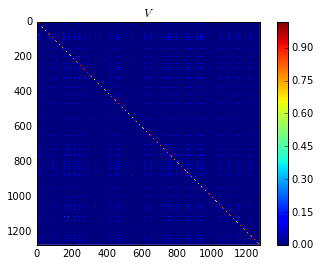

In [70]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(clusterdist_df, interpolation='none')
ax = plt.gca()
#plt.xticks(list(range(len(v_df.columns.values))))
#plt.yticks(list(range(len(v_df.index.values))))
plt.title("$V$")
#ax.set_xticklabels(v_df.columns.values, rotation=90)
plt.colorbar()

In [107]:
clusterdist_df = dist_df.max().max() - dist_df
clusterdist_df.min().min(), clusterdist_df.max().max()

(0.0, 1.0190974431039388)

In [228]:
count = 0
for paper in clusterdist_df.columns:
    count += 1
    sim_papers_df = clusterdist_df.sort(columns=paper, ascending=False)[paper]
    #print(sim_papers_df)
    sim_papers = sim_papers_df.index
    clusterdist_df.loc[paper, paper] = 1.0
    clusterdist_df.loc[sim_papers[:10],sim_papers[:10]] = 1.0
    clusterdist_df.loc[sim_papers[10:],sim_papers[:10]] = 0.0
    clusterdist_df.loc[sim_papers[:10],sim_papers[10:]] = 0.0
print(count)
clusterdist_df
#clusterdist_df = clusterdist_df.sort(ascending=False)
#clusterdist_df

/home/ec/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:4: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


1275


,0_0,0_1,0_3,0_4,0_5,0_6,0_7,0_8,0_11,0_12,...,52_1,52_2,52_3,52_4,52_5,52_6,52_7,52_8,52_9,52_10
0_0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0_1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0_3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0_4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0_5,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0_6,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0_7,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0_8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
0_11,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0_12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [102]:
clusterdist_df.loc[sim_papers[:10],sim_papers[:10]]
clusterdist_df.loc[sim_papers[10:],sim_papers[:10]]
clusterdist_df.loc[sim_papers[:10],sim_papers[10:]]

,51_1,9_53,12_13,27_3,20_17,43_10,34_1,4_11,42_9,47_29,...,13_19,35_73,35_171,14_17,32_23,36_10,35_71,12_9,50_7,52_10
35_75,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
33_11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
35_27,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
42_13,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25_36,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
35_120,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14_88,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
35_80,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2_23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14_35,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [104]:
for paper in clusterdist_df.columns:
    print(paper)
    print(clusterdist_df[paper].value_counts())
    print()

0_0
0.000000    1054
0.070836       1
0.106689       1
0.090348       1
0.078561       1
0.085781       1
0.096647       1
0.077963       1
0.066390       1
0.068810       1
0.071083       1
0.077729       1
0.066553       1
0.120242       1
0.111505       1
0.085878       1
0.107854       1
0.071736       1
0.073858       1
0.085626       1
0.071762       1
0.068473       1
0.071193       1
0.057159       1
0.065856       1
0.182832       1
0.113884       1
0.107394       1
0.141029       1
0.091670       1
            ... 
0.074861       1
0.123982       1
0.069972       1
0.091202       1
0.065571       1
0.159083       1
0.083815       1
0.066007       1
0.066230       1
0.115271       1
0.083048       1
0.116672       1
0.062640       1
0.103639       1
0.119408       1
0.121243       1
0.072804       1
0.077597       1
0.132626       1
0.103916       1
0.095601       1
0.078369       1
0.068194       1
0.097226       1
0.084181       1
0.115924       1
0.066300       1
0.093649  

In [106]:
p = '49_15'
test_papers_df = dist_df.sort(columns=p, ascending=False)[p]
t_papers = test_papers_df.index
test_papers_df.iloc[:10],t_papers[:10]

/home/ec/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:2: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  from ipykernel import kernelapp as app


(44_4      1.026994
 32_11     1.026434
 35_95     1.025530
 10_19     1.023773
 40_11     1.022868
 14_131    1.022351
 35_219    1.022096
 35_230    1.022070
 35_10     1.021444
 35_143    1.021396
 Name: 49_15, dtype: float64,
 Index(['44_4', '32_11', '35_95', '10_19', '40_11', '14_131', '35_219',
        '35_230', '35_10', '35_143'],
       dtype='object'))

In [108]:
p = '49_15'
test_papers_df = clusterdist_df.sort(columns=p, ascending=False)[p]
t_papers = test_papers_df.index
test_papers_df.iloc[:10],t_papers[:10]

/home/ec/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:2: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  from ipykernel import kernelapp as app


(49_15     0.900678
 35_43     0.247392
 35_5      0.234287
 39_19     0.205607
 35_27     0.190104
 35_191    0.189718
 25_29     0.178074
 35_4      0.165392
 17_0      0.164259
 14_35     0.159031
 Name: 49_15, dtype: float64,
 Index(['49_15', '35_43', '35_5', '39_19', '35_27', '35_191', '25_29', '35_4',
        '17_0', '14_35'],
       dtype='object'))

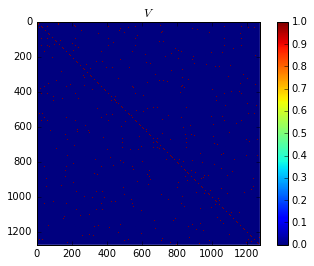

In [229]:
plt.imshow(clusterdist_df, interpolation='none')
ax = plt.gca()
#plt.xticks(list(range(len(v_df.columns.values))))
#plt.yticks(list(range(len(v_df.index.values))))
plt.title("$V$")
#ax.set_xticklabels(v_df.columns.values, rotation=90)
plt.colorbar()

In [111]:
sortedcdist_df = clusterdist_df.sort(ascending=False)

/home/ec/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(....) is deprecated, use sort_index(.....)
  if __name__ == '__main__':


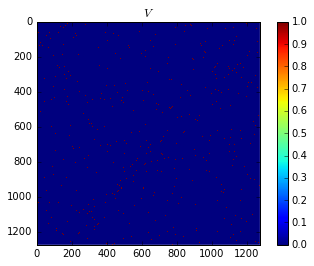

In [112]:
plt.imshow(sortedcdist_df, interpolation='none')
ax = plt.gca()
#plt.xticks(list(range(len(v_df.columns.values))))
#plt.yticks(list(range(len(v_df.index.values))))
plt.title("$V$")
#ax.set_xticklabels(v_df.columns.values, rotation=90)
plt.colorbar()

[253, 431, 936, 1049, 1092, 1125, 1274, 115, 47, 101, 173, 270, 866, 881, 1202, 1272, 1053, 1117, 57, 59, 217, 421, 453, 974, 978, 1105, 1115, 1229, 1253, 1271, 62, 134, 201, 274, 362, 532, 575, 996, 1033, 1270, 229, 360, 393, 418, 463, 588, 608, 819, 905, 1269, 202, 227, 263, 382, 795, 884, 942, 1001, 1074, 1268, 146, 365, 375, 395, 459, 843, 987, 1048, 1245, 1267, 18, 361, 400, 487, 497, 872, 1251, 1266, 1050, 1081, 136, 247, 289, 339, 351, 430, 432, 903, 1002, 1265, 183, 264, 330, 490, 503, 761, 1120, 1264, 2, 111, 121, 157, 188, 347, 533, 768, 797, 1263, 1042, 1086, 98, 271, 444, 599, 755, 1060, 1077, 1119, 1168, 1262, 106, 350, 536, 895, 902, 904, 1057, 1173, 1174, 1261, 61, 97, 66, 73, 186, 372, 526, 721, 1136, 1260, 102, 159, 483, 312, 314, 499, 1217, 1259, 527, 1068, 321, 520, 831, 863, 894, 980, 1010, 1258, 182, 194, 439, 1028, 1142, 1214, 1257, 545, 707, 110, 5, 103, 593, 601, 603, 720, 1112, 1238, 1256, 470, 129, 307, 433, 537, 652, 701, 794, 940, 1252, 1255, 87, 232, 153, 3

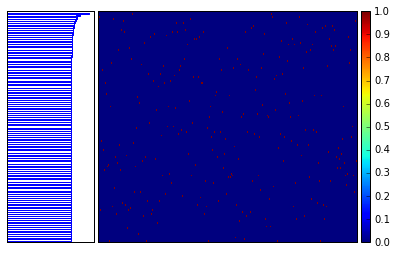

In [113]:
import scipy.cluster.hierarchy as sch
import pylab
# Compute and plot dendrogram.
fig = pylab.figure()
axdendro = fig.add_axes([0.09,0.1,0.2,0.8])
Y = sch.linkage(sortedcdist_df, method='centroid')
Z = sch.dendrogram(Y, orientation='right')
axdendro.set_xticks([])
axdendro.set_yticks([])

# Plot distance matrix.
axmatrix = fig.add_axes([0.3,0.1,0.6,0.8])
index = Z['leaves']
print(index)
sortedcdist_df = sortedcdist_df.iloc[index,:]
sortedcdist_df = sortedcdist_df.iloc[:,index]
im = axmatrix.matshow(sortedcdist_df, aspect='auto', origin='lower')
axmatrix.set_xticks([])
axmatrix.set_yticks([])

# Plot colorbar.
axcolor = fig.add_axes([0.91,0.1,0.02,0.8])
pylab.colorbar(im, cax=axcolor)

#### Reordering and Evaluation of possible clustering techniques

In [ ]:
clusterdist_df = dist_df.max().max() - dist_df
clusterdist_df.min().min(), clusterdist_df.max().max()

In [230]:
dictsts = {}
#p = '49_15'
#clusterdist_df[p][clusterdist_df[p] == 1.0].index
for paper in clusterdist_df.columns:
    for op in clusterdist_df[paper][clusterdist_df[paper] == 1.0].index:
        if op not in dictsts:
            dictsts[op] = []
        dictsts[op].append(paper)


In [231]:
len(dictsts.keys())

1275

In [232]:
sorted([(k,v) for k, v in dictsts.items()], key=lambda x:len(x[1]), reverse=True)[:20]

[('14_29',
  ['14_29',
   '14_95',
   '14_158',
   '22_45',
   '29_6',
   '29_16',
   '35_16',
   '35_136',
   '39_10',
   '41_6']),
 ('0_7',
  ['0_7',
   '1_8',
   '7_14',
   '7_21',
   '11_0',
   '11_11',
   '24_6',
   '35_57',
   '40_16',
   '47_5']),
 ('20_3',
  ['0_12',
   '10_14',
   '18_12',
   '20_3',
   '20_7',
   '21_7',
   '22_41',
   '32_23',
   '36_15',
   '37_19']),
 ('50_13',
  ['2_38',
   '5_0',
   '14_80',
   '22_42',
   '25_41',
   '34_9',
   '35_200',
   '38_1',
   '44_7',
   '50_13']),
 ('18_15',
  ['11_13',
   '14_128',
   '14_134',
   '18_15',
   '22_29',
   '35_34',
   '35_101',
   '43_1',
   '43_27',
   '46_2']),
 ('0_0',
  ['0_0',
   '2_15',
   '7_9',
   '27_10',
   '29_26',
   '31_2',
   '36_8',
   '39_22',
   '44_0',
   '50_0']),
 ('29_39',
  ['6_17',
   '9_10',
   '9_32',
   '22_4',
   '25_1',
   '29_39',
   '29_50',
   '35_129',
   '43_48',
   '44_5']),
 ('46_4',
  ['1_10',
   '2_11',
   '18_6',
   '25_43',
   '35_204',
   '36_19',
   '46_4',
   '47_3',
   

In [233]:
dictsts2 = {}
#p = '49_15'
#clusterdist_df[p][clusterdist_df[p] == 1.0].index
for paper in clusterdist_df.columns:
    for op in clusterdist_df[paper][clusterdist_df[paper] == 1.0].index:
        if op not in dictsts2:
            dictsts2[op] = 0
        dictsts2[op] = dictsts2[op] + 1

In [234]:
sorted([(k,v) for k, v in dictsts2.items()], key=lambda x:x[1], reverse=True)[:20]

[('14_29', 10),
 ('0_7', 10),
 ('20_3', 10),
 ('50_13', 10),
 ('18_15', 10),
 ('0_0', 10),
 ('29_39', 10),
 ('46_4', 10),
 ('32_30', 10),
 ('20_10', 10),
 ('43_41', 10),
 ('9_59', 10),
 ('23_10', 10),
 ('37_2', 10),
 ('46_7', 10),
 ('36_30', 10),
 ('7_14', 10),
 ('20_1', 10),
 ('1_8', 10),
 ('47_36', 10)]

In [235]:
for k in dictsts['14_29']:
    print(k, dictsts[k])

14_29 ['14_29', '14_95', '14_158', '22_45', '29_6', '29_16', '35_16', '35_136', '39_10', '41_6']
14_95 ['14_29', '14_95', '14_158', '22_45', '29_6', '29_16', '35_16', '35_136', '39_10', '41_6']
14_158 ['14_29', '14_95', '14_158', '22_45', '29_6', '29_16', '35_16', '35_136', '39_10', '41_6']
22_45 ['14_29', '14_95', '14_158', '22_45', '29_6', '29_16', '35_16', '35_136', '39_10', '41_6']
29_6 ['14_29', '14_95', '14_158', '22_45', '29_6', '29_16', '35_16', '35_136', '39_10', '41_6']
29_16 ['14_29', '14_95', '14_158', '22_45', '29_6', '29_16', '35_16', '35_136', '39_10', '41_6']
35_16 ['14_29', '14_95', '14_158', '22_45', '29_6', '29_16', '35_16', '35_136', '39_10', '41_6']
35_136 ['14_29', '14_95', '14_158', '22_45', '29_6', '29_16', '35_16', '35_136', '39_10', '41_6']
39_10 ['14_29', '14_95', '14_158', '22_45', '29_6', '29_16', '35_16', '35_136', '39_10', '41_6']
41_6 ['14_29', '14_95', '14_158', '22_45', '29_6', '29_16', '35_16', '35_136', '39_10', '41_6']


In [236]:
nodes = {}
counter = 0
for k in dictsts:
    if set(dictsts[k]) not in list(nodes.values()):
        nodes[counter] = set(dictsts[k])
        counter += 1
len(nodes), nodes[0]

(128,
 {'14_158',
  '14_29',
  '14_95',
  '22_45',
  '29_16',
  '29_6',
  '35_136',
  '35_16',
  '39_10',
  '41_6'})

In [237]:
idist_df, U, sigma, V, v_df = similarityanalysis(words_df, 0)

In [238]:
len(idist_df)

1275

In [239]:
dictsts3 = {}
for n in nodes:
    if n not in dictsts3:
        dictsts3[n] = []

#p = '49_15'
#clusterdist_df[p][clusterdist_df[p] == 1.0].index
for paper in idist_df.columns:
    test_papers_df = idist_df.sort(columns=paper, ascending=True)[paper][:2]
    ii = test_papers_df.index
    #print(list(ii)[1])
    mynode = -1
    for s in nodes:
        if paper in nodes[s]:
            mynode = s
            break
    for d in nodes:
        if list(ii)[1] in nodes[d]:
            yournode = d
            break   
    dictsts3[s].append(d)
    

        


/home/ec/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


In [240]:
dictsts3[3], nodes[90]

([64, 38, 15, 68, 93, 97, 127, 50, 50, 57],
 {'0_8',
  '12_3',
  '14_93',
  '16_5',
  '35_29',
  '35_59',
  '42_24',
  '42_26',
  '49_17',
  '52_7'})

In [241]:
nodes[3], nodes[90]

({'14_80',
  '22_42',
  '25_41',
  '2_38',
  '34_9',
  '35_200',
  '38_1',
  '44_7',
  '50_13',
  '5_0'},
 {'0_8',
  '12_3',
  '14_93',
  '16_5',
  '35_29',
  '35_59',
  '42_24',
  '42_26',
  '49_17',
  '52_7'})

In [242]:
for s in nodes[3]:
    print(' '.join(textreference[s]['treated_st']))

switched career due love happiness
php sass summer start learn sass want challenge learn something new realize want pursue career field
excited want share others could appreciate
get frustrate many time worth change career something free
start new job two week excited
plan make career web development importantly remote web developer
excited terrified largely terrify announce first ever interview front end developer job today
excited see new career front
get sense approach new problem
decide call recruitment agency however see vid


In [243]:
for s in nodes[90]:
    print(' '.join(textreference[s]['treated_st']))

know long shot junior
special thanks slowdata trion fuego314 kunalgupta05 discussion every question need answer get demotivated n't anyone talk feel lonely feel entirely web development study suggest join us never regret link https
log answer wrap iffe settimeout
metric matter learn something today answer win
anyone question i’d happy answer best
member point review project equally well answer question
best possibly n't try customize answer system test make sure pass test well
i’m happy answer question guy
here’s github here’s fcc front end certificate here’s blog here’s day cod log
ready apply job simple answer capable build simple full stack application provide plenty code sample github show consistent improvement


In [244]:
fd3 = collections.Counter()
for s in nodes[3]:
    for ch in textreference[s]['treated_st']:
        fd3[ch] += 1
print(len(fd3), fd3.most_common(15))

59 [('career', 5), ('excited', 4), ('new', 4), ('want', 3), ('job', 2), ('developer', 2), ('start', 2), ('get', 2), ('sass', 2), ('see', 2), ('web', 2), ('learn', 2), ('front', 2), ('something', 2), ('share', 1)]


In [245]:
quickrev3 = {}
for k in fd3:
    if k in wordimportance:
        #print(k, fd6[k]*wordimportance[k])
        #quickrev[k] = fd6[k]*wordimportance[k]
        quickrev3[k] = wordimportance[k]
sorted([(k, v) for k,v in quickrev3.items()], key= lambda x: x[1], reverse=True)[:20]

[('excited', 0.6287320315082972),
 ('plan', 0.6287320315082972),
 ('largely', 0.6256756478792005),
 ('due', 0.5663060955865232),
 ('pursue', 0.5663060955865232),
 ('appreciate', 0.5663060955865232),
 ('change', 0.5436031119241098),
 ('remote', 0.5362934124678861),
 ('field', 0.5362934124678861),
 ('worth', 0.5362934124678861),
 ('php', 0.5238253205128844),
 ('agency', 0.5038127068980577),
 ('realize', 0.5031366197159807),
 ('summer', 0.5029856252066376),
 ('career', 0.5023400821588561),
 ('today', 0.49886894204026316),
 ('approach', 0.4883059956300043),
 ('love', 0.47094382702392756),
 ('share', 0.4697292298142434),
 ('frustrate', 0.4676769787591145)]

In [246]:
fd90 = collections.Counter()
for s in nodes[90]:
    for ch in textreference[s]['treated_st']:
        fd90[ch] += 1
print(len(fd90), fd90.most_common(15))

87 [('answer', 8), ('question', 4), ('here’s', 4), ('anyone', 2), ('feel', 2), ('best', 2), ('simple', 2), ('test', 2), ('log', 2), ('github', 2), ('well', 2), ('happy', 2), ("n't", 2), ('every', 1), ('lonely', 1)]


In [247]:
quickrev90 = {}
for k in fd90:
    if k in wordimportance:
        #print(k, fd6[k]*wordimportance[k])
        #quickrev[k] = fd6[k]*wordimportance[k]
        quickrev90[k] = wordimportance[k]
sorted([(k, v) for k,v in quickrev90.items()], key= lambda x: x[1], reverse=True)[:20]

[('us', 0.6235693050121527),
 ('review', 0.6075289416452574),
 ('possibly', 0.5487558362442895),
 ('provide', 0.5475847405562899),
 ('certificate', 0.547178351269894),
 ('answer', 0.5436031119241098),
 ('pass', 0.5436031119241098),
 ('https', 0.5362934124678861),
 ('show', 0.5337363372937846),
 ('thanks', 0.5305501981129807),
 ('anyone', 0.5238253205128844),
 ('test', 0.5032813176581179),
 ('i’d', 0.5031366197159807),
 ('blog', 0.5029856252066376),
 ('never', 0.4995553646552769),
 ('today', 0.49886894204026316),
 ('link', 0.49886894204026316),
 ('join', 0.49462329918009607),
 ('long', 0.4694955405255206),
 ('happy', 0.46782403761874314)]

In [249]:
dictsts3[6], nodes[68]

([65, 68, 123, 68, 78, 73, 51, 68, 113, 125],
 {'19_11',
  '22_15',
  '22_56',
  '25_28',
  '29_7',
  '35_126',
  '35_228',
  '40_33',
  '44_3',
  '6_21'})

In [250]:
for s in nodes[6]:
    print(' '.join(textreference[s]['treated_st']))

study something like five eight month
n't care show recruiter employer best project ever
n't shy talk capable skill
take time it’s annoying besides get attention employer care cover letter
however could devote much time learning work equally well
start meeting say talk would meet salary requirement would willing negotiation month time
first time part community peer could talk professionally something care
random call final interview care think way problem ability method find something don’t know
get hire part time nanny gig find fcc week drop spend learning
help support surround unprecedented something legend


In [251]:
for s in nodes[68]:
    print(' '.join(textreference[s]['treated_st']))

time felt like day would never come continue work towards goal it’s inevitable you’ll reach jon
time you’ll get better better
get interview time city
felt like drown first
run thing work even difficult need time find solution
dark time felt like revert time get depressed ass go find work
trial error reveal work time
time besides work profession
felt brave enough try build udacity neighborhood map project knockout
decide go much time take


In [252]:
fd6 = collections.Counter()
for s in nodes[6]:
    for ch in textreference[s]['treated_st']:
        fd6[ch] += 1
print(len(fd6), fd6.most_common(15))

73 [('time', 5), ('care', 4), ('something', 4), ('talk', 3), ('would', 2), ('part', 2), ('get', 2), ('could', 2), ('learning', 2), ('month', 2), ('find', 2), ("n't", 2), ('employer', 2), ('say', 1), ('help', 1)]


In [253]:
quickrev6 = {}
for k in fd6:
    if k in wordimportance:
        #print(k, fd6[k]*wordimportance[k])
        #quickrev6[k] = fd6[k]*wordimportance[k]
        quickrev6[k] = wordimportance[k]
sorted([(k, v) for k,v in quickrev6.items()], key= lambda x: x[1], reverse=True)[:20]

[('willing', 0.6285903846154612),
 ('five', 0.5663060955865232),
 ('shy', 0.5663060955865232),
 ('show', 0.5337363372937846),
 ('meet', 0.5038105020509541),
 ('support', 0.5029856252066376),
 ('gig', 0.5029856252066376),
 ('part', 0.4939523983365122),
 ('community', 0.48744660456831523),
 ('spend', 0.47160017610042726),
 ('salary', 0.46782403761874314),
 ('capable', 0.4676769787591145),
 ('say', 0.45968193972196353),
 ('well', 0.45599046156861067),
 ('professionally', 0.4525096472150858),
 ('random', 0.4525096472150858),
 ('ever', 0.44691117705657174),
 ('would', 0.44226668501199196),
 ('learning', 0.44195869231482265),
 ('equally', 0.43270457523624245)]

In [254]:
fd68 = collections.Counter()
for s in nodes[68]:
    for ch in textreference[s]['treated_st']:
        fd68[ch] += 1
len(fd68), fd68.most_common(10)

(51,
 [('time', 9),
  ('work', 5),
  ('felt', 4),
  ('like', 3),
  ('get', 3),
  ('better', 2),
  ('go', 2),
  ('find', 2),
  ('you’ll', 2),
  ('take', 1)])

In [255]:
quickrev68 = {}
for k in fd68:
    if k in wordimportance:
        #print(k, fd6[k]*wordimportance[k])
        #quickrev[k] = fd6[k]*wordimportance[k]
        quickrev68[k] = wordimportance[k]
sorted([(k, v) for k,v in quickrev68.items()], key= lambda x: x[1], reverse=True)[:20]

[('difficult', 0.6235693050121527),
 ('ass', 0.5663060955865232),
 ('profession', 0.5663060955865232),
 ('felt', 0.5493442450837549),
 ('run', 0.5362934124678861),
 ('enough', 0.5038105020509541),
 ('never', 0.4995553646552769),
 ('continue', 0.49886894204026316),
 ('goal', 0.4883059956300043),
 ('reach', 0.4791366479867536),
 ('inevitable', 0.4525096472150858),
 ('towards', 0.4525096472150858),
 ('depressed', 0.4525096472150858),
 ('city', 0.44691117705657174),
 ('decide', 0.445430938780194),
 ('would', 0.44226668501199196),
 ('come', 0.4382684206727029),
 ('try', 0.417548301264498),
 ('solution', 0.4106885554172174),
 ('besides', 0.36774448376036917)]

In [275]:
dictsts3[8], nodes[126]

([126, 126, 61, 116, 93, 123, 43, 82, 126, 78],
 {'13_17',
  '14_41',
  '1_9',
  '22_20',
  '23_5',
  '29_28',
  '2_20',
  '36_32',
  '37_5',
  '7_22'})

In [276]:
for s in nodes[8]:
    print(' '.join(textreference[s]['treated_st']))

tailor local market condition
wan na say thanks success story cod friend local fcc group everyone i’ve meet throughout journey help succeed become developer
startup company approach group find intern build prototype app
may one one others may group
get current job help free code camp course lot online resource
get good pay learn good designing skill
learn besides get involve local fcc group find another local group dedicate help people learn tech skill online
appreciate incorporate self teaching skill gain learn experience fcc
find fcc excited immediately know would spend month learn coding skill
apply least job online indeed go tech fair communicate recruiter success


In [277]:
for s in nodes[126]:
    print(' '.join(textreference[s]['treated_st']))

js project website quit job apply apply applied reach recruiter recruiter
group find first job
find way bypass get dream job
without fcc would reach far
reach first hurdle beginning stage picture dream job
hurdle tame async beast
beginning frequently look thing mdn understand people’s code wasn’t working cement knowledge explain
hope story motivate encouraging enough everyone get dream job future
take approximately month study untill first job
always learning goal reach


In [278]:
fd8 = collections.Counter()
for s in nodes[8]:
    for ch in textreference[s]['treated_st']:
        fd8[ch] += 1
print(len(fd8), fd8.most_common(15))

75 [('group', 5), ('learn', 5), ('skill', 4), ('local', 4), ('fcc', 4), ('online', 3), ('get', 3), ('help', 3), ('find', 3), ('job', 2), ('tech', 2), ('success', 2), ('may', 2), ('one', 2), ('good', 2)]


In [279]:
quickrev8 = {}
for k in fd8:
    if k in wordimportance:
        #print(k, fd6[k]*wordimportance[k])
        #quickrev6[k] = fd6[k]*wordimportance[k]
        quickrev8[k] = wordimportance[k]
sorted([(k, v) for k,v in quickrev8.items()], key= lambda x: x[1], reverse=True)[:20]

[('excited', 0.6287320315082972),
 ('immediately', 0.6287320315082972),
 ('communicate', 0.6235693050121527),
 ('fair', 0.5663060955865232),
 ('appreciate', 0.5663060955865232),
 ('journey', 0.5493442450837549),
 ('local', 0.545064671358979),
 ('thanks', 0.5305501981129807),
 ('everyone', 0.5038105020509541),
 ('meet', 0.5038105020509541),
 ('self', 0.5031366197159807),
 ('tech', 0.5031366197159807),
 ('online', 0.49886894204026316),
 ('coding', 0.4939523983365122),
 ('become', 0.4939523983365122),
 ('approach', 0.4883059956300043),
 ('current', 0.4883059956300043),
 ('success', 0.4791366479867536),
 ('another', 0.4718022888410949),
 ('story', 0.47163275870844074)]

In [280]:
fd126 = collections.Counter()
for s in nodes[126]:
    for ch in textreference[s]['treated_st']:
        fd126[ch] += 1
print(len(fd126), fd126.most_common(15))

54 [('job', 6), ('reach', 4), ('first', 3), ('dream', 3), ('hurdle', 2), ('get', 2), ('recruiter', 2), ('beginning', 2), ('find', 2), ('apply', 2), ('motivate', 1), ('group', 1), ('quit', 1), ('everyone', 1), ('people’s', 1)]


In [281]:
quickrev126 = {}
for k in fd126:
    if k in wordimportance:
        #print(k, fd6[k]*wordimportance[k])
        #quickrev6[k] = fd6[k]*wordimportance[k]
        quickrev126[k] = wordimportance[k]
sorted([(k, v) for k,v in quickrev126.items()], key= lambda x: x[1], reverse=True)[:20]

[('frequently', 0.6285903846154612),
 ('beginning', 0.6235693050121527),
 ('explain', 0.6235693050121527),
 ('working', 0.5663060955865232),
 ('picture', 0.5663060955865232),
 ('hope', 0.5487558362442895),
 ('quit', 0.5362934124678861),
 ('website', 0.5305501981129807),
 ('knowledge', 0.5305501981129807),
 ('everyone', 0.5038105020509541),
 ('enough', 0.5038105020509541),
 ('wasn’t', 0.5031366197159807),
 ('js', 0.5031366197159807),
 ('future', 0.5029856252066376),
 ('far', 0.5023400821588561),
 ('dream', 0.49462329918009607),
 ('goal', 0.4883059956300043),
 ('understand', 0.4883059956300043),
 ('reach', 0.4791366479867536),
 ('story', 0.47163275870844074)]

In [302]:
groups = collections.defaultdict(list)
for n in dictsts3:
    if collections.Counter(dictsts3[n]).most_common(1)[0][1] >= 2:
        if collections.Counter(dictsts3[n]).most_common(1)[0][0] == n:
            print(n, None)
        else:
            print(n, collections.Counter(dictsts3[n]).most_common(1)[0])
            groups[collections.Counter(dictsts3[n]).most_common(1)[0][0]].append(n)
    else:
        print(n, None)

0 (51, 3)
1 (18, 3)
2 None
3 (50, 2)
4 (68, 3)
5 None
6 (68, 3)
7 None
8 (126, 3)
9 None
10 None
11 None
12 None
13 None
14 None
15 (83, 2)
16 None
17 None
18 None
19 None
20 (0, 2)
21 None
22 None
23 (68, 3)
24 None
25 (65, 2)
26 (97, 2)
27 None
28 (65, 2)
29 (65, 2)
30 None
31 (57, 2)
32 None
33 None
34 (123, 2)
35 None
36 None
37 None
38 None
39 None
40 (126, 2)
41 None
42 (68, 2)
43 (51, 2)
44 (68, 2)
45 None
46 None
47 (3, 3)
48 (125, 3)
49 (124, 2)
50 None
51 None
52 None
53 (49, 2)
54 (68, 2)
55 (65, 2)
56 None
57 None
58 None
59 (116, 2)
60 (51, 2)
61 None
62 (38, 2)
63 None
64 None
65 None
66 (93, 3)
67 (65, 2)
68 None
69 None
70 None
71 (97, 2)
72 (5, 2)
73 None
74 (2, 2)
75 (78, 4)
76 (83, 2)
77 (65, 2)
78 None
79 (37, 2)
80 (1, 2)
81 (83, 2)
82 (123, 3)
83 None
84 (65, 4)
85 (83, 2)
86 (105, 3)
87 (32, 2)
88 None
89 (51, 2)
90 None
91 (18, 2)
92 (97, 2)
93 None
94 (51, 2)
95 (68, 2)
96 (65, 2)
97 None
98 (83, 2)
99 (65, 3)
100 None
101 None
102 (83, 2)
103 None
104 (68, 3)


In [305]:
[xx for x in groups.values() for xx in x]

[20,
 80,
 74,
 47,
 72,
 1,
 91,
 112,
 87,
 79,
 62,
 53,
 3,
 0,
 43,
 60,
 89,
 94,
 108,
 120,
 124,
 31,
 117,
 119,
 25,
 28,
 29,
 55,
 67,
 77,
 84,
 96,
 99,
 125,
 4,
 6,
 23,
 42,
 44,
 54,
 95,
 104,
 111,
 75,
 113,
 115,
 15,
 76,
 81,
 85,
 98,
 102,
 66,
 26,
 71,
 92,
 86,
 114,
 59,
 34,
 82,
 49,
 127,
 48,
 8,
 40]

In [306]:
for i in range(128):
    if i not in [xx for x in groups.values() for xx in x] and i not in groups:
        groups[i] = []
len(groups)

70

In [307]:
groups

defaultdict(list,
            {0: [20],
             1: [80],
             2: [74],
             3: [47],
             5: [72],
             7: [],
             9: [],
             10: [],
             11: [],
             12: [],
             13: [],
             14: [],
             16: [],
             17: [],
             18: [1, 91],
             19: [],
             21: [],
             22: [],
             23: [112],
             24: [],
             27: [],
             30: [],
             32: [87],
             33: [],
             35: [],
             36: [],
             37: [79],
             38: [62],
             39: [],
             41: [],
             45: [],
             46: [],
             49: [53],
             50: [3],
             51: [0, 43, 60, 89, 94, 108, 120, 124],
             52: [],
             56: [],
             57: [31, 117, 119],
             58: [],
             61: [],
             63: [],
             64: [],
             65: [25, 28, 29, 55, 67

In [284]:
collections.Counter(dictsts3[n]).most_common(1)

[(51, 3)]

In [146]:
sorted([(k,len(v)) for k, v in dictsts3.items()], key=lambda x:x[1], reverse=True)[:20]

[]

In [ ]:
import scipy
numpy.where(words_df.iloc[:,0] != 0)
scipy.spatial.distance.cosine(words_df.iloc[:,0],words_df.iloc[:,1])
words_df.index[numpy.where(words_df.iloc[:,0] != 0)].values, words_df.index[numpy.where(words_df.iloc[:,1] != 0)].values
sklearn.metrics.pairwise.cosine_similarity(words_df.loc[:,'0_0'],words_df.loc[:,'3_12'])
1-scipy.spatial.distance.cosine(words_df.loc[:,'0_0'],words_df.loc[:,'3_12'])

In [ ]:
lda_model, lsi_model, redo_corpus_by_sts, corpus, dictionary = gensim_models2(lemmposrecs, wordimportance = {'tfidf':True})

In [ ]:
lda_model.print_topics()

In [ ]:
lda_model, lsi_model, redo_corpus_by_sts, corpus, dictionary = gensim_models2(lemmposrecs, wordimportance = wordimportance)

In [ ]:
lda_model.print_topics()

In [ ]:
lsi_model.print_topics()

## Keyphrase Extraction and Graph Analysis

### TODO
* based on http://bdewilde.github.io/blog/2014/09/23/intro-to-automatic-keyphrase-extraction/
* see also, either for new information or to remind me of things I know:
 * https://www.nltk.org/book/ch07.html
 * http://pythonnotesbyajay.blogspot.com/2013/03/pythons-itertoolstee-explained-with.html
 * https://www.blog.pythonlibrary.org/2016/04/20/python-201-an-intro-to-itertools/
 * http://code.activestate.com/recipes/305588-simple-example-to-show-off-itertoolstee/ (good example of tee, BAD explanation!)
 * http://www.bogotobogo.com/python/python_fncs_map_filter_reduce.php

In [42]:
def extract_candidate_chunks(text, grammar=r'KT: {(<JJ>* <NN.*>+ <IN>)? <JJ>* <NN.*>+}'):
    import itertools, nltk, string
    
    # exclude candidates that are stop words or entirely punctuation
    punct = set(string.punctuation)
    stop_words = set(nltk.corpus.stopwords.words('english'))
    # tokenize, POS-tag, and chunk using regular expressions
    chunker = nltk.chunk.regexp.RegexpParser(grammar)
    tagged_sents = nltk.pos_tag_sents(nltk.word_tokenize(sent) for sent in nltk.sent_tokenize(text))
    all_chunks = list(itertools.chain.from_iterable(nltk.chunk.tree2conlltags(chunker.parse(tagged_sent))
                                                    for tagged_sent in tagged_sents))
    #print(all_chunks)
    # join constituent chunk words into a single chunked phrase
    candidates = [' '.join(word for word, pos, chunk in group).lower()
                  for key, group in itertools.groupby(all_chunks, lambda w_TUPLE: w_TUPLE[2] != 'O') if key]

    return [cand for cand in candidates
            if cand not in stop_words and not all(char in punct for char in cand)]


def score_keyphrases_by_tfidf(texts, candidates='chunks'):
    import gensim, nltk
    
    # extract candidates from each text in texts, either chunks or words
    if candidates == 'chunks':
        boc_texts = [extract_candidate_chunks(text) for text in texts]
    elif candidates == 'words':
        boc_texts = [extract_candidate_words(text) for text in texts]
    # make gensim dictionary and corpus
    dictionary = gensim.corpora.Dictionary(boc_texts)
    corpus = [dictionary.doc2bow(boc_text) for boc_text in boc_texts]
    # transform corpus with tf*idf model
    tfidf = gensim.models.TfidfModel(corpus)
    corpus_tfidf = tfidf[corpus]
    
    return corpus_tfidf, dictionary

def extract_candidate_words(text, good_tags=set(['JJ','JJR','JJS','NN','NNP','NNS','NNPS'])):
    import itertools, nltk, string

    # exclude candidates that are stop words or entirely punctuation
    punct = set(string.punctuation)
    stop_words = set(nltk.corpus.stopwords.words('english'))
    # tokenize and POS-tag words
    tagged_words = itertools.chain.from_iterable(nltk.pos_tag_sents(nltk.word_tokenize(sent)
                                                                    for sent in nltk.sent_tokenize(text)))
    # filter on certain POS tags and lowercase all words
    candidates = [word.lower() for word, tag in tagged_words
                  if tag in good_tags and word.lower() not in stop_words
                  and not all(char in punct for char in word)]

    return candidates


def score_keyphrases_by_textrank(text, n_keywords=0.05):
    #from itertools import takewhile, tee, izip
    import itertools # better as it is more explicit
    import networkx, nltk
    
    # tokenize for all words, and extract *candidate* words
    words = [word.lower()
             for sent in nltk.sent_tokenize(text)
             for word in nltk.word_tokenize(sent)]
    candidates = extract_candidate_words(text)
    #candidates = extract_candidate_chunks(text)
    # build graph, each node is a unique candidate
    graph = networkx.Graph()
    graph.add_nodes_from(set(candidates))
    # iterate over word-pairs, add unweighted edges into graph
    def pairwise(iterable):
        """s -> (s0,s1), (s1,s2), (s2, s3), ..."""
        a, b = itertools.tee(iterable)
        next(b, None)
        return zip(a, b) #python3 default `zip` is ok but slightly slower
    for w1, w2 in pairwise(candidates):
        if w2:
            graph.add_edge(*sorted([w1, w2]))
    # score nodes using default pagerank algorithm, sort by score, keep top n_keywords
    ranks = networkx.pagerank(graph)
    if 0 < n_keywords < 1:
        n_keywords = int(round(len(candidates) * n_keywords))
    word_ranks = {word_rank[0]: word_rank[1]
                  #for word_rank in sorted(ranks.iteritems(), key=lambda x: x[1], reverse=True)[:n_keywords]}
                  for word_rank in sorted(list(ranks.items()), key=lambda x: x[1], reverse=True)[:n_keywords]} #python3 doesnt use `iteritems`
    keywords = set(word_ranks.keys())
    # merge keywords into keyphrases
    keyphrases = {}
    j = 0
    for i, word in enumerate(words):
        if i < j:
            continue
        if word in keywords:
            kp_words = list(itertools.takewhile(lambda x: x in keywords, words[i:i+10]))
            avg_pagerank = sum(word_ranks[w] for w in kp_words) / float(len(kp_words))
            keyphrases[' '.join(kp_words)] = avg_pagerank
            # counter as hackish way to ensure merged keyphrases are non-overlapping
            j = i + len(kp_words)
    
    return sorted(list(keyphrases.items()), key=lambda x: x[1], reverse=True)

In [19]:
for u in allrecords:
    #block arguments
    record = u["data"]
    forumpost = record['forum']['foundjob_msg']['text']
    if forumpost == '':
        continue
    forumpostID = record['forum']['foundjob_msg']['id']
    forumpostLINK = record['forum']['foundjob_msg']['link']
    soup_forumpost = BeautifulSoup(forumpost)
    soup_forumpostTEXT = soup_forumpost.find('body').get_text()
    break
soup_forumpostTEXT

/home/ec/anaconda3/lib/python3.5/site-packages/bs4/__init__.py:166: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

To get rid of this warning, change this:

 BeautifulSoup([your markup])

to this:

 BeautifulSoup([your markup], "lxml")

  markup_type=markup_type))


"So, yesterday I finally got my 1st job in coding, and particularly in machine learning! Really excited to share with you guys man! And whole lot of thanks to everyone on FCC! You guys are really awesome!\nI think ended up getting a job in the field of machine learning is a quite a different experience from most FCCers, so I hope that sharing these experience with you guys will help you on your decisions making when searching for your dream job in the future, and also open up more options to choose which field to specialise after finishing FCC extensive curriculum. Here is my story and experience to share with you guys.\nSo I started out on FCC in July last year after dropping out from my university since I couldn't transfer my degree to CS. It was long long hours of coding back then until December when I started FCC backend projects pair-programming with another FCCer. At that time, she and I were also searching for jobs, and since we lived in the same city, and so we can help out eac

In [32]:
candidates = extract_candidate_chunks(soup_forumpostTEXT)
candidates

['yesterday',
 'job in coding',
 'machine learning',
 'share',
 'man',
 'whole lot of thanks',
 'everyone on fcc',
 'guys',
 'job',
 'field of machine learning',
 'different experience',
 'fccers',
 'experience',
 'decisions',
 'dream job',
 'future',
 'options',
 'field',
 'fcc extensive curriculum',
 'story',
 'experience',
 'share',
 'fcc in july last year',
 'university',
 'degree',
 'cs',
 'long hours',
 'december',
 'fcc backend projects',
 'fccer',
 'time',
 'jobs',
 'same city',
 'jobs',
 'job on ui',
 'css',
 'rwd',
 'angularjs',
 'node.js',
 'matter as frontend',
 'backend',
 'fullstack developer',
 'few times',
 'city',
 'pay',
 'junior developer',
 'country',
 'working holiday visa',
 'uk',
 'progressive experiences on ui',
 'good pay',
 'good designing skills',
 'fcc backend projects',
 'projects',
 'ideas',
 'angularjs',
 'node.js skills',
 'few months',
 'article about machine learning',
 'legendary battle between lee sedol',
 'alphago',
 'pay',
 'data scientist',
 'coun

In [41]:
candidates = extract_candidate_words(soup_forumpostTEXT)
candidates

['yesterday',
 'job',
 'coding',
 'machine',
 'learning',
 'share',
 'man',
 'whole',
 'lot',
 'thanks',
 'everyone',
 'fcc',
 'guys',
 'awesome',
 'job',
 'field',
 'machine',
 'learning',
 'different',
 'experience',
 'fccers',
 'experience',
 'decisions',
 'dream',
 'job',
 'future',
 'options',
 'field',
 'fcc',
 'extensive',
 'curriculum',
 'story',
 'experience',
 'share',
 'fcc',
 'july',
 'last',
 'year',
 'university',
 'degree',
 'cs',
 'long',
 'hours',
 'december',
 'fcc',
 'backend',
 'projects',
 'fccer',
 'time',
 'jobs',
 'city',
 'jobs',
 'job',
 'ui',
 'css',
 'rwd',
 'angularjs',
 'node.js',
 'matter',
 'frontend',
 'backend',
 'fullstack',
 'developer',
 'times',
 'city',
 'pay',
 'junior',
 'developer',
 'country',
 'low',
 'working',
 'holiday',
 'visa',
 'uk',
 'progressive',
 'experiences',
 'ui',
 'good',
 'pay',
 'good',
 'designing',
 'skills',
 'fcc',
 'backend',
 'projects',
 'projects',
 'ideas',
 'angularjs',
 'node.js',
 'skills',
 'months',
 'article',


In [44]:
final = score_keyphrases_by_textrank(soup_forumpostTEXT, n_keywords=.30)
final

[('fcc', 0.04009317119801634),
 ('fcc curriculum', 0.02356957832417548),
 ('skills', 0.023233040425601786),
 ('fcc backend projects', 0.021854310460715187),
 ('job', 0.01943304494933276),
 ('backend skills', 0.018927980213844762),
 ('coding skills', 0.016636179311391747),
 ('good', 0.01654703925944602),
 ('lots', 0.015076817805564368),
 ('good pay', 0.015005320004032277),
 ('backend', 0.014622920002087736),
 ('node.js skills', 0.014573608888288323),
 ('dream job', 0.013622036889133455),
 ('pay', 0.013463600748618534),
 ('good friend', 0.012877125285671295),
 ('fullstack', 0.012061818972126267),
 ('everyone', 0.011338401934982865),
 ('low pay', 0.010975901079911175),
 ('projects', 0.010846840182041483),
 ('story', 0.01069736872942959),
 ('experience', 0.0102826618116633),
 ('fullstack dev', 0.010066584583404526),
 ('coding', 0.010039318197181705),
 ('fullstack developer', 0.010025102339104558),
 ('city', 0.009973267584340462),
 ('data science', 0.00979275417973402),
 ('hard', 0.00969897